# InSAR - Remove Phase Ramp

## Estimate and Remove a Linear Phase Ramp from Differential Interferograms.

In [1]:
# - python dependencies
import numpy as np
import rasterio
import matplotlib.pyplot as plt
# - program dependencies
from utils.mpl_utils import add_colorbar
from remove_phase_ramp import estimate_phase_ramp

<Figure size 432x288 with 0 Axes>

## Import sample differential Interferogram

In [2]:
# - Absolute Path to input interferogram
path_to_intf = './data/diff_ingram_test.tiff'

# - Import interferometric phase using rasterio
with rasterio.open(path_to_intf, mode="r+") as dataset_c:
    # - Read Input Raster and Binary Mask
    clipped_raster = np.array(dataset_c.read(1),
                              dtype=dataset_c.dtypes[0])
    # - Define Valid data mask
    raster_mask = np.array(dataset_c.read_masks(1),
                           dtype=dataset_c.dtypes[0])
    raster_mask[raster_mask == 255] = 1.
    raster_mask[raster_mask == 0] = np.nan

# - Transform the Input Phase Field into a complex array
dd_phase_complex = np.exp(1j * clipped_raster)

# - Generate synthetic field domain
array_dim = dd_phase_complex.shape
n_rows = array_dim[0]
n_columns = array_dim[1]

## Plot Input Interferometric Phase

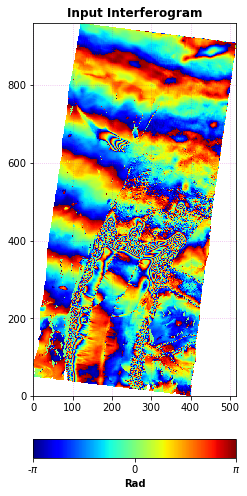

In [3]:
fig_1 = plt.figure(figsize=(8, 8))
ax_1 = fig_1.add_subplot(121)
ax_1.set_title('Input Interferogram', weight='bold')
im_1 = ax_1.pcolormesh(clipped_raster * raster_mask,
                       vmin=-np.pi, vmax=np.pi,
                       cmap=plt.cm.get_cmap('jet'))
cb_1 = add_colorbar(fig_1, ax_1, im_1)
cb_1.set_label(label='Rad', weight='bold')
cb_1.ax.set_xticks([-np.pi, 0, np.pi])
cb_1.ax.set_xticklabels([r'-$\pi$', '0', r'$\pi$'])
ax_1.grid(color='m', linestyle='dotted', alpha=0.3)
plt.show()

## Define Grid-Search Parameters

In [4]:
# - Parameters
freq_r = 7            # - Number of Cycles along rows direction
freq_c = 2            # - Number of Cycles along columns direction
slope_r = 1             # - Phase ramp slope along the ramp main diagonal
slope_c = 1             # - Phase ramp slope along the ramp main diagonal
s_radius = 2          # - grid-search radius
s_step = 0.1          # - grid-search step

In [5]:
print('# - Running Grid-Search around first guess.')
e_ramp = estimate_phase_ramp(dd_phase_complex, freq_r, freq_c,
                             slope_r=slope_r, slope_c=slope_c,
                             s_radius=s_radius, s_step=s_step)
xx_m = e_ramp['xx_m']
yy_m = e_ramp['yy_m']
n_cycle_c_vect_f_xx = e_ramp['n_cycle_c_vect_f_xx']
n_cycle_c_vect_f = e_ramp['n_cycle_c_vect_f']
n_cycle_r_vect_f_yy = e_ramp['n_cycle_r_vect_f_yy']
n_cycle_r_vect_f = e_ramp['n_cycle_r_vect_f']
error_array_f = e_ramp['error_array_f']

# - Find location of the Minimum Phase Absolute Error Value
ind_min = np.where(error_array_f == np.nanmin(error_array_f))
n_cycle_c_min = np.round(n_cycle_c_vect_f[ind_min[1]][0], decimals=3)
n_cycle_r_min = np.round(n_cycle_r_vect_f[ind_min[0]][0], decimals=3)

print('# - Minimum Found:')
print(f'# - Num. Cycles -> Rows : {n_cycle_r_min}')
print(f'# - Num. Cycles -> Columns : {n_cycle_c_min}')

# - Running Grid-Search around first guess.


100%|███████████████████████| 41/41 [00:28<00:00,  1.42it/s]

# - Minimum Found:
# - Num. Cycles -> Rows : 6.7
# - Num. Cycles -> Columns : 1.1


## Show Grid-Search - Error Function

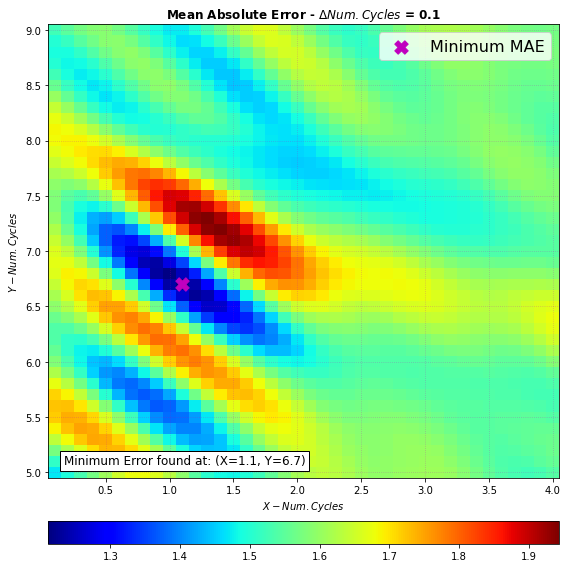

In [6]:
# - Plot Error Array
fig_0 = plt.figure(figsize=(8, 8))
ax_0 = fig_0.add_subplot(111)
ax_0.set_title(r'Mean Absolute Error - '
               rf'$\Delta Num. Cycles$ = {s_step}', weight='bold')
ax_0.set_xlabel(r'$X - Num. Cycles$')
ax_0.set_ylabel(r'$Y - Num. Cycles$')
ag_0 = ax_0.pcolormesh(n_cycle_c_vect_f_xx, n_cycle_r_vect_f_yy,
                       error_array_f, cmap=plt.cm.get_cmap('jet'))
ax_0.scatter(n_cycle_c_vect_f_xx[ind_min],
             n_cycle_r_vect_f_yy[ind_min],
             marker='X', color='m', s=180, label='Minimum MAE')
cb_0 = add_colorbar(fig_0, ax_0, ag_0)
ax_0.legend(loc='best', prop={'size': 16})
ax_0.grid(color='m', linestyle='dotted', alpha=0.3)
txt = f'Minimum Error found at: (X={n_cycle_c_min}, Y={n_cycle_r_min})'
ax_0.annotate(txt, xy=(0.03, 0.03), xycoords="axes fraction",
              size=12, zorder=100,
              bbox=dict(boxstyle="square", fc="w"))
plt.tight_layout()
plt.show()
plt.close()

## Remove the estimate phase ramp from the input interferogram

In [7]:
# - Generate Synthetic Phase Ramp
n_cycle_r = n_cycle_r_vect_f[ind_min[0]]
n_cycle_c = n_cycle_c_vect_f[ind_min[1]]
synth_real = slope_c * (2 * np.pi / n_columns) * n_cycle_c * xx_m
synth_imag = slope_r * (2 * np.pi / n_rows) * n_cycle_r * yy_m
synth_phase_plane = synth_real + synth_imag
synth_complex = np.exp(1j * synth_phase_plane)
synth_wrapped = np.angle(synth_complex)

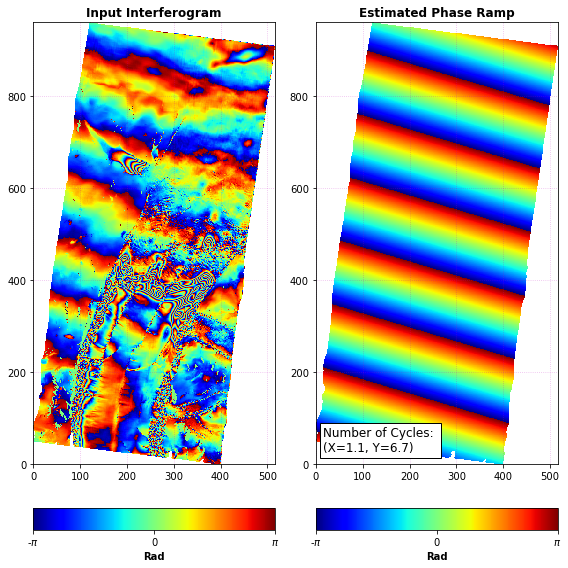

In [8]:
# - Compare Estimated Phase Ramp with input interferogram.
fig_1 = plt.figure(figsize=(8, 8))
ax_1 = fig_1.add_subplot(121)
ax_1.set_title('Input Interferogram', weight='bold')
im_1 = ax_1.pcolormesh(clipped_raster * raster_mask,
                       vmin=-np.pi, vmax=np.pi,
                       cmap=plt.cm.get_cmap('jet'))
cb_1 = add_colorbar(fig_1, ax_1, im_1)
cb_1.set_label(label='Rad', weight='bold')
cb_1.ax.set_xticks([-np.pi, 0, np.pi])
cb_1.ax.set_xticklabels([r'-$\pi$', '0', r'$\pi$'])
ax_1.grid(color='m', linestyle='dotted', alpha=0.3)

ax_2 = fig_1.add_subplot(122)
ax_2.set_title('Estimated Phase Ramp', weight='bold')
im_2 = ax_2.pcolormesh(synth_wrapped * raster_mask,
                       cmap=plt.cm.get_cmap('jet'))
cb_2 = add_colorbar(fig_1, ax_2, im_2)
cb_2.set_label(label='Rad', weight='bold')
cb_2.ax.set_xticks([-np.pi, 0, np.pi])
cb_2.ax.set_xticklabels([r'-$\pi$', '0', r'$\pi$'])
ax_2.grid(color='m', linestyle='dotted', alpha=0.3)

txt = f'Number of Cycles: \n(X={n_cycle_c_min}, Y={n_cycle_r_min})'
ax_2.annotate(txt, xy=(0.03, 0.03), xycoords="axes fraction",
              size=12, zorder=100,
              bbox=dict(boxstyle="square", fc="w"))
plt.tight_layout()
# -
plt.show()
plt.close()

## Remove the estimated phase ramp from the input phase field.

In [9]:
# - Remove the estimated phase ramp from the input phase field.
# - Compute the complex conjugate product between the input phase
# - field and the estimated ramp.
dd_phase_complex_corrected \
    = np.angle(dd_phase_complex * np.conj(synth_complex))

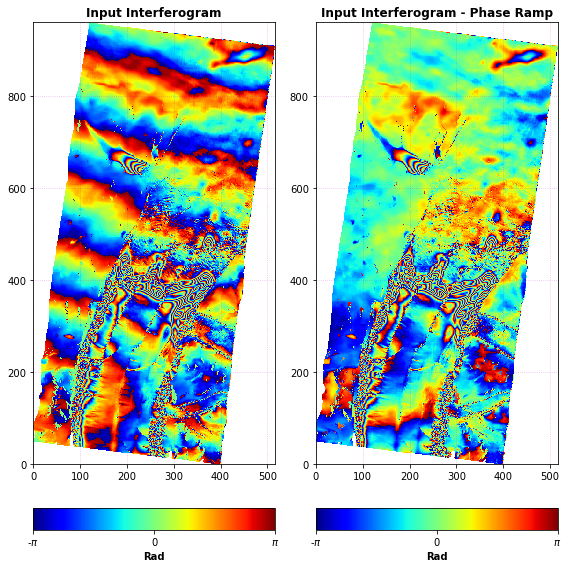

In [10]:
fig_3 = plt.figure(figsize=(8, 8))
ax_3 = fig_3.add_subplot(121)
ax_3.set_title('Input Interferogram', weight='bold')
im_3a = ax_3.pcolormesh(clipped_raster * raster_mask,
                        vmin=-np.pi, vmax=np.pi,
                        cmap=plt.cm.get_cmap('jet'))
cb_3a = add_colorbar(fig_3, ax_3, im_3a)
cb_3a.set_label(label='Rad', weight='bold')
cb_3a.ax.set_xticks([-np.pi, 0, np.pi])
cb_3a.ax.set_xticklabels([r'-$\pi$', '0', r'$\pi$'])
ax_3.grid(color='m', linestyle='dotted', alpha=0.3)

ax_3 = fig_3.add_subplot(122)
ax_3.set_title('Input Interferogram - Phase Ramp', weight='bold')
im_3b = ax_3.pcolormesh(dd_phase_complex_corrected * raster_mask,
                        cmap=plt.cm.get_cmap('jet'))
cb_3b = add_colorbar(fig_3, ax_3, im_3b)
cb_3b.set_label(label='Rad', weight='bold')
cb_3b.ax.set_xticks([-np.pi, 0, np.pi])
cb_3b.ax.set_xticklabels([r'-$\pi$', '0', r'$\pi$'])
ax_3.grid(color='m', linestyle='dotted', alpha=0.3)
plt.tight_layout()
# -
plt.show()
plt.close()